In [8]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime

from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from collections import Counter

In [9]:
from keras.models import Model
from keras.layers import Dense, Dropout, GaussianNoise
from keras.layers import Input, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l1, l2 , l1_l2


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import r2_score, matthews_corrcoef, f1_score, mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

# Hyperparameters

In [10]:
START, END = 10000, 50000
WINDOW = 100
HORIZON = 25
TRAIN_TEST_SPLIT = 0.75

# Data reading

In [11]:
bars = pd.read_csv('tick_bars.csv')[START:END]

In [12]:
del bars['DateTime']

In [13]:
bars.head()

close    high      low     open  volume
10000  52.3600  52.450  52.1012  52.1012   24122
10001  52.5500  52.616  52.3500  52.3600   25097
10002  52.6600  52.770  52.4800  52.5500   25890
10003  52.6438  52.780  52.6000  52.6500   28254
10004  52.1400  52.900  52.1200  52.6600   34310

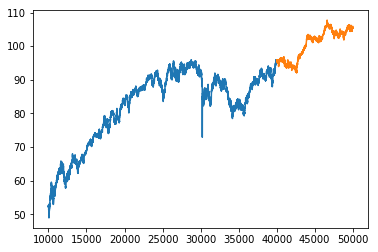

In [14]:
plt.figure()
plt.plot(bars.close[:int(len(bars) * TRAIN_TEST_SPLIT)])
plt.plot(bars.close[int(len(bars) * TRAIN_TEST_SPLIT):])
plt.show()

# Data preparation

In [15]:
inputs = bars[['close', 'high', 'low', 'open', 'volume']]
outputs = bars['close']

scaler_x = StandardScaler()
inputs = scaler_x.fit_transform(inputs)

scaler_y = StandardScaler()
outputs = scaler_y.fit_transform(outputs.reshape(-1, 1))

/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda2/lib/python2.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [16]:
X, Y = [], []

for i in range(WINDOW, END-HORIZON-START, 1):
    
    window = inputs[i-WINDOW:i]
    future = outputs[i+HORIZON, 0] # 0 stands for the close price

    X.append(window)
    Y.append(future)
    
X, Y = np.array(X), np.array(Y)

In [17]:
X.shape, Y.shape

((39875, 100, 5), (39875,))

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle = False)

In [19]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((29906, 100, 5), (29906,), (9969, 100, 5), (9969,))

# Modeling

In [20]:
def nn(shape):
    main_input = Input(shape=shape, name='main_input')
    x = Flatten()(main_input)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.25)(x)
    output = Dense(1, activation = "linear")(x)
    
    final_model = Model(inputs=[main_input], outputs=[output])
    return final_model

In [21]:
model = nn((WINDOW, X_train.shape[2], ))
model.summary()

model.compile(optimizer='adam', loss=['mse'])

checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=0, save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, Y_train, 
              validation_data = (X_test, Y_test),
              epochs = 100, 
              batch_size = 16, 
              verbose=True, 
              callbacks=[checkpointer, es],
              shuffle=True
                )

model.load_weights("test.hdf5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100, 5)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                25050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 25,101
Trainable params: 25,101
Non-trainable params: 0
_________________________________________________________________
Train on 29906 samples, validate on 9969 samples
Epoch 1/100
29906/29906 [==============================] - 7s 224us/step - loss: 0.1207 -

# Evaluation

In [22]:
pred_test = model.predict(X_test)

In [23]:
pred_test_inv = scaler_y.inverse_transform(pred_test)
real_test_inv = scaler_y.inverse_transform(Y_test)

In [24]:
print 'scaled', mean_absolute_error(Y_test, pred_test), r2_score(Y_test, pred_test)
print 'real', mean_absolute_error(real_test_inv, pred_test_inv), r2_score(real_test_inv, pred_test_inv)

scaled 0.036203094245763755 0.9817259046817388
real 0.44994731608293337 0.981725909322557


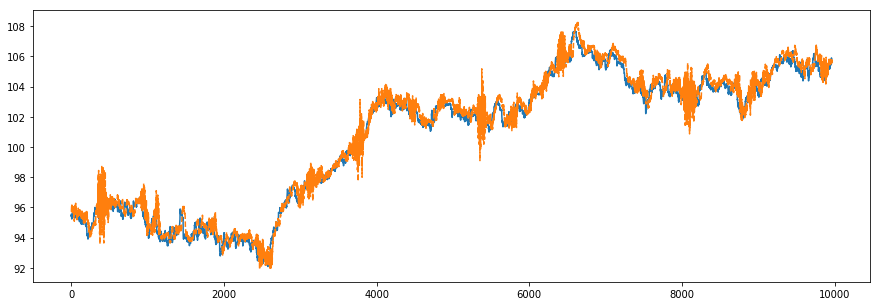

In [25]:
plt.figure(figsize = (15, 5))
plt.plot(real_test_inv)
plt.plot(pred_test_inv, ls = '--')
plt.show()

In [26]:
import numpy
import tensorflow
import keras

In [27]:
numpy.__version__

'1.14.1'

In [28]:
tensorflow.__version__

'1.5.0'

In [29]:
keras.__version__

'2.1.6'

In [45]:
from keras.optimizers import Adam

In [87]:
X = np.array([1,2,3,4,5]) # np.arange(-10, 11, 0.05)
Y = X**2

In [88]:
main_input = Input(shape=(1,) , name='main_input')
x = Dense(10, activation = 'relu')(main_input)
output = Dense(1, activation = "linear")(x)

model = Model(inputs=[main_input], outputs=[output])
model.compile(optimizer=Adam(0.1), loss=['mse'])

In [89]:
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=0, save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X, Y,
              epochs = 500, 
              verbose=True, 
              callbacks=[checkpointer, es],
              shuffle=True)

Epoch 1/500
5/5 [==============================] - 1s 103ms/step - loss: 169.8315
Epoch 2/500
5/5 [==============================] - 0s 2ms/step - loss: 134.9138
Epoch 3/500
5/5 [==============================] - 0s 2ms/step - loss: 95.5132
Epoch 4/500
5/5 [==============================] - 0s 2ms/step - loss: 57.8655
Epoch 5/500
5/5 [==============================] - 0s 511us/step - loss: 29.3710
Epoch 6/500
5/5 [==============================] - 0s 1ms/step - loss: 18.5148
Epoch 7/500
5/5 [==============================] - 0s 542us/step - loss: 29.2404
Epoch 8/500
5/5 [==============================] - 0s 2ms/step - loss: 47.1902
Epoch 9/500
5/5 [==============================] - 0s 3ms/step - loss: 53.1579
Epoch 10/500
5/5 [==============================] - 0s 782us/step - loss: 46.0149
Epoch 11/500
5/5 [==============================] - 0s 1ms/step - loss: 33.5815
Epoch 12/500
5/5 [==============================] - 0s 2ms/step - loss: 22.8289
Epoch 13/500
5/5 [=====================

Epoch 103/500
5/5 [==============================] - 0s 540us/step - loss: 0.9347
Epoch 104/500
5/5 [==============================] - 0s 701us/step - loss: 0.9081
Epoch 105/500
5/5 [==============================] - 0s 597us/step - loss: 0.8833
Epoch 106/500
5/5 [==============================] - 0s 461us/step - loss: 0.8602
Epoch 107/500
5/5 [==============================] - 0s 607us/step - loss: 0.8375
Epoch 108/500
5/5 [==============================] - 0s 617us/step - loss: 0.8141
Epoch 109/500
5/5 [==============================] - 0s 551us/step - loss: 0.7920
Epoch 110/500
5/5 [==============================] - 0s 424us/step - loss: 0.7732
Epoch 111/500
5/5 [==============================] - 0s 496us/step - loss: 0.7552
Epoch 112/500
5/5 [==============================] - 0s 660us/step - loss: 0.7381
Epoch 113/500
5/5 [==============================] - 0s 826us/step - loss: 0.7204
Epoch 114/500
5/5 [==============================] - 0s 721us/step - loss: 0.7012
Epoch 115/500
5/

Epoch 204/500
5/5 [==============================] - 0s 780us/step - loss: 0.1192
Epoch 205/500
5/5 [==============================] - 0s 846us/step - loss: 0.1173
Epoch 206/500
5/5 [==============================] - 0s 920us/step - loss: 0.1155
Epoch 207/500
5/5 [==============================] - 0s 696us/step - loss: 0.1136
Epoch 208/500
5/5 [==============================] - 0s 491us/step - loss: 0.1118
Epoch 209/500
5/5 [==============================] - 0s 594us/step - loss: 0.1099
Epoch 210/500
5/5 [==============================] - 0s 766us/step - loss: 0.1080
Epoch 211/500
5/5 [==============================] - 0s 817us/step - loss: 0.1062
Epoch 212/500
5/5 [==============================] - 0s 624us/step - loss: 0.1043
Epoch 213/500
5/5 [==============================] - 0s 506us/step - loss: 0.1025
Epoch 214/500
5/5 [==============================] - 0s 511us/step - loss: 0.1007
Epoch 215/500
5/5 [==============================] - 0s 521us/step - loss: 0.0989
Epoch 216/500
5/

Epoch 304/500
5/5 [==============================] - 0s 619us/step - loss: 0.0127
Epoch 305/500
5/5 [==============================] - 0s 567us/step - loss: 0.0124
Epoch 306/500
5/5 [==============================] - 0s 815us/step - loss: 0.0120
Epoch 307/500
5/5 [==============================] - 0s 518us/step - loss: 0.0117
Epoch 308/500
5/5 [==============================] - 0s 565us/step - loss: 0.0114
Epoch 309/500
5/5 [==============================] - 0s 625us/step - loss: 0.0111
Epoch 310/500
5/5 [==============================] - 0s 490us/step - loss: 0.0108
Epoch 311/500
5/5 [==============================] - 0s 571us/step - loss: 0.0105
Epoch 312/500
5/5 [==============================] - 0s 532us/step - loss: 0.0102
Epoch 313/500
5/5 [==============================] - 0s 525us/step - loss: 0.0099
Epoch 314/500
5/5 [==============================] - 0s 775us/step - loss: 0.0096
Epoch 315/500
5/5 [==============================] - 0s 1ms/step - loss: 0.0093
Epoch 316/500
5/5 

Epoch 404/500
5/5 [==============================] - 0s 551us/step - loss: 4.8574e-04
Epoch 405/500
5/5 [==============================] - 0s 572us/step - loss: 4.6790e-04
Epoch 406/500
5/5 [==============================] - 0s 448us/step - loss: 4.5075e-04
Epoch 407/500
5/5 [==============================] - 0s 593us/step - loss: 4.3407e-04
Epoch 408/500
5/5 [==============================] - 0s 604us/step - loss: 4.1804e-04
Epoch 409/500
5/5 [==============================] - 0s 518us/step - loss: 4.0256e-04
Epoch 410/500
5/5 [==============================] - 0s 562us/step - loss: 3.8765e-04
Epoch 411/500
5/5 [==============================] - 0s 714us/step - loss: 3.7323e-04
Epoch 412/500
5/5 [==============================] - 0s 531us/step - loss: 3.5927e-04
Epoch 413/500
5/5 [==============================] - 0s 489us/step - loss: 3.4588e-04
Epoch 414/500
5/5 [==============================] - 0s 562us/step - loss: 3.3290e-04
Epoch 415/500
5/5 [==============================] - 0

Epoch 500/500
5/5 [==============================] - 0s 421us/step - loss: 9.1127e-06


In [90]:
pred = model.predict(X)

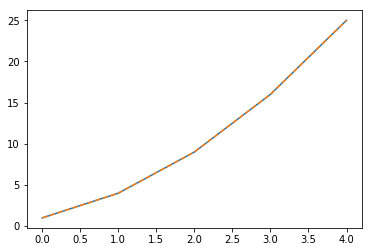

In [91]:
plt.figure()
plt.plot(Y)
plt.plot(pred, ls = '--')
plt.show()